# setup

## magic commands

In [0]:
# "magic" commands, prefaced with "%", changes settings in the notebook

# this ensures plots are embedded in notebook web page
%matplotlib inline

# pdb = Python debugger, so this command turns the debugger OFF
%pdb off

Automatic pdb calling has been turned OFF


## NumPy, SciPy, Matplotlib, SymPy

In [0]:
# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# animation
from matplotlib import animation as animation
from IPython.display import HTML
mpl.rc('animation', html='jshtml')
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym


## OS and Colab/Jupyter 

In [0]:
# os = operating system; access OS-level commands
# e.g. create directory, delete file, execute command
# (more platform-independent than "!")
import os

In [0]:
# test whether this is a Colaboratory or Jupyter notebook
try:
  import google.colab
  COLAB = True
  print('Colaboratory Notebook')
except:
  COLAB = False
  print('Jupyter Notebook')

Colaboratory Notebook


In [0]:
# Colab notebook
if COLAB:
  # pip = Python package manager; "!" means "run at system level"
  !pip install slycot
  !pip install control
  
  # render SymPy equations nicely in Colaboratory Notebook
  def colab_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
  
  sym.init_printing(use_latex="mathjax",latex_printer=colab_latex_printer)

# Jupyter notebook
else:
  init_printing(use_latex='mathjax')

# Python's Control Systems Toolbox
import control as ctrl

# SciPy module that implements many of the routines in ctrl
from scipy import signal as sig

     |████████████████████████████████| 1.5MB 4.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.3.5-cp36-cp36m-linux_x86_64.whl size=1413039 sha256=ed1283a85ef9f7e845f861e4213a140a5460b61a0dc444b1ab90ca37337e5838
  Stored in directory: /root/.cache/pip/wheels/44/a0/1a/2357a505e49314f194d8de50d5ce0a87b368b323ce70b34d16
Successfully built slycot
     |████████████████████████████████| 256kB 4.7MB/s 
  Created wheel for control: filename=control-0.8.3-py2.py3-none-any.whl size=260982 sha256=a08df82059d496b5659b69a2ea5246b8977b006e4da017a8f0898c8c8d8f1985
  Stored in directory: /root/.cache/pip/wheels/c2/d9/cc/90b28cb139a6320a3af2285428b6da87eee8d8920c78bb0223
Successfully built control


## helpful functions

In [0]:
def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

# simulation and visualization

## cruise control (linear)

Consider the (negative) feedback block diagram:

![feedback block diagram](http://faculty.uw.edu/sburden/447/447-hw1-feedback.png)

We can derive the transfer function that relates output $y$ to external inputs $v$ and $r$ using ***block diagram algebra*** as follows:

$$
y 
= P(v + u)
= P(v + C(r-y))
= P v + PC r - PC y
$$

$$
\iff
(1+PC) y = P v + PC r
\iff 
y = \frac{P}{1 + PC} v + \frac{PC}{1 + PC} r.
$$

Consider the first-order process model

$$ P(s) = \frac{b}{s + a} $$

that corresponds to the differential equation

$$ \dot{y} + a y = b u $$

and suppose $a, b > 0$.

This model arises in many physical systems -- velocity or angular velocity of a mechanical system; temperature of a material; liquid flowing in and out of a reservoir.

For concreteness, let's consider $P$ as a model for the velocity of a car:
* $y$ -- car velocity;
* $u$ -- throttle (gas pedal);
* $b$ -- unit conversion from force to acceleration;
* $a$ -- air resistance, wheel friction, etc;
* $r$ -- desired velocity;
* $v$ -- road slope, headwind, etc.


Let's start by applying proportional control, $C(s) = k_P$.

In [0]:
# note:  this command creates Python variables s, a, b, k_P
# and specifies that s can be any complex number but a, b, k_P are positive real
sym.var('s',complex=True) # equivalent to s = sym.symbols('s')
sym.var('a,b,k_P',positive=True)

P = b / (s + a)
C = k_P

G_yv = P / (1 + P * C)

# un-simplified
print('unsimplified G_yv =',G_yv)

# simplified
G_yv = sym.simplify(G_yv)
print('simplified G_yv =',G_yv)

# formatted 
G_yv

unsimplified G_yv = b/((a + s)*(b*k_P/(a + s) + 1))
simplified G_yv = b/(a + b*k_P + s)


      b      
─────────────
a + b⋅k_P + s

In [0]:
# SymPy can tell me the LaTeX code corresponding to an expression
print(sym.latex(G_yv))

\frac{b}{a + b k_{P} + s}


In [0]:
# numerator and denominator of rational function G_yv
# den is the characteristic polynomial of G_yv
num,den = sym.fraction(G_yv)

roots = sym.solve(den, s)

print('roots of characteristic polynomial s =',roots)

roots of characteristic polynomial s = [-a - b*k_P]


In [0]:
# since we specified a, b, k_P > 0, SymPy knows the root is negative
roots[0].is_negative

True

In [0]:
# static gain (AKA DC gain) G_yv(0)
G_yv.subs(s,0) # equivalently: G_yv.subs({s:0})

    b    
─────────
a + b⋅k_P

For any $k_P > 0$, the root $s = -a - b k_P < 0$ so the system is stable and the static gain satisfies

$$ 0 < = \frac{b}{a + b k_P} < \frac{b}{a + b \cdot 0} = \frac{b}{a}, $$

which means that the ***proportional controller*** $C(s) = k_P$ attenuates the steady-state error caused by a constant disturbance.

In [0]:
sym.var('k_I')

C = k_P + k_I/s

G_yv = P / (1 + P * C)

G_yv = sym.simplify(G_yv)

G_yv

            b⋅s            
───────────────────────────
b⋅(k_I + k_P⋅s) + s⋅(a + s)

In [0]:
num,den = sym.fraction(G_yv)

print('roots of characteristic polynomial s =')
sym.solve(den, s)

roots of characteristic polynomial s =


⎡                 ____________________________________                   _____
⎢                ╱  2                2    2                             ╱  2  
⎢  a   b⋅k_P   ╲╱  a  + 2⋅a⋅b⋅k_P + b ⋅k_P  - 4⋅b⋅k_I     a   b⋅k_P   ╲╱  a  +
⎢- ─ - ───── - ───────────────────────────────────────, - ─ - ───── + ────────
⎣  2     2                        2                       2     2             

_______________________________⎤
              2    2           ⎥
 2⋅a⋅b⋅k_P + b ⋅k_P  - 4⋅b⋅k_I ⎥
───────────────────────────────⎥
           2                   ⎦

In [0]:
# static gain (AKA DC gain)
G_yv.subs(s,0) # equivalently: G_yv.subs({s:0})

0

Since the static gain is zero, the ***proportional-integral*** controller $C(s) = k_P + k_I / s$ zeros the steady-state error caused by a constant disturbance.

## cruise control (nonlinear)

Force balance on car chassis yields

$$ m \dot{v} = F - F_d $$

where:
* $m$ is mass of car, passengers, and load;
* $v$ is velocity / speed of car;
* $F$ is engine force, which is proportional to control signal $0 \le u \le 1$ that specifies throttle position (that, in turn, specifies fuel injection rate), and varies nonlinearly with engine (angular) speed $\omega$,

* * $ F = \frac{R u}{r} T(\omega),\ \omega = \frac{R}{r} v, $

* * $ T(\omega) = T_m \cdot \left( 1 - \beta \cdot \left( \frac{\omega}{\omega_m} - 1 \right)^2 \right), $

* * $T_m$ is the maximum engine torque (supplied at speed $\omega_m$), $R$ is the gear ratio, and $r$ is the wheel radius;

* $F_d = F_g + F_r + F_a$ is disturbance force where:
* * $F_g = m g \sin\theta$ is the fraction of gravitational acceleration $g$ converted to gravitational force when the road has slope $\theta$;
* * $F_r = m g C_r \frac{v}{|v|}$ is the rolling / road frictional force with coefficient of friction $C_r$;
* * $F_a = \frac{1}{2} \rho C_d A |v| v$ is the aerodynamic drag force from air density $\rho$, frontal car area $A$, and (shape-dependent) coefficient of aerodynamic drag $C_d$.

Taken together, we have a nonlinear differential equation that relates control input $u$ to the rate of change in car velocity $v$:

$$ m \dot{v} = \frac{R}{r} u T\left(\frac{R}{r} v \right) - m g \sin\theta - m g C_r \frac{v}{|v|} - \frac{1}{2} \rho C_d A |v| v. $$

In [0]:
# 2011 Ford Focus SE
m = 1500. # kg
# parameter values from [AMv2 Ch 4.1]
alpha_n = 40
r = 0.5 # m 
R = alpha_n * r
T_m = 190 # Nm
beta = 0.4
omega_m = 420 # rad/sec ~= 4000 RPM
g = 9.8 # m / sec^2
C_r = 0.01
rho = 1.3 # kg / m^3
C_d = 0.32
A = 2.4 # m^2

# proportional-integral controller parameters
k_P = 0.5
k_I = 0.1

# reference velocity -- can vary over time
v_r = lambda t : 20. * np.ones_like(t) # m / sec

# road slope increases by 4 deg at time 5 sec
theta = lambda t : 4 * (np.pi/180) * (t >= 5.) # rad

In [0]:
# engine torque depends on engine (rotational) velocity
def T(omega):
  return T_m * (1 - beta * (omega / omega_m - 1.)**2)

# differential equation satisfied by car velocity:  \dot{v} = f(v,u)
def dv(t,v,u): 
  return (1./m) * ((R/r) * u * T((R/r) * v)         # F
                   - m * g * np.sin(theta(t))       # F_g
                   - m * g * C_r * v / np.abs(v)    # F_r
                   - (1./2) * rho * C_d * A * v**2) # F_a

# differential equation satisfied by proportional-integral controller state
def dz(t,v):
  return v_r(t) - v

# proportional-integral controller
def u(t,v,z):
  return k_P * (v_r(t) - v) + k_I * z

In [0]:
# initialize at reference velocity
v0 = v_r(0.) # m / sec

# integrator state that makes v0 an equilibrium
u0 = op.root(lambda u : dv(0.,v0,u),0.)['x'][0]
z0 = u0 / k_I

# controlled system state consists of car velocity and error integral
x0 = np.asarray([v0,z0])

def f(t,x):
  v,z = x
  return np.asarray([dv(t,v,u(t,v,z)),dz(t,v)])

print('x0 an equilibrium? ',np.allclose(f(0.,x0),0.))

x0 an equilibrium?  True


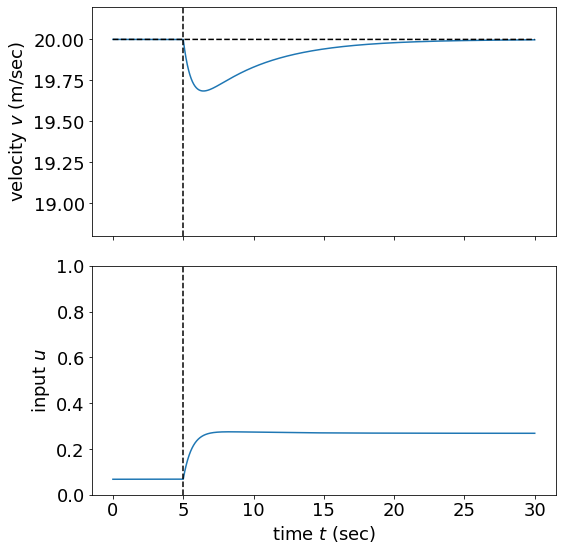

In [0]:
t = 30. # sec; simulation duration

t_,x_ = numerical_simulation(f,t,x0)

v_,z_ = x_.T

plt.figure(figsize=(8,8))

ax = plt.subplot(2,1,1)
ylim = (18.8,20.2)
ax.plot(t_,v_)
ax.plot(5.*np.ones(2),ylim,'k--')
ax.plot(t_,v_r(t_),'k--')
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_ylabel(r'velocity $v$ (m/sec)')


ax = plt.subplot(2,1,2)
ylim = (0.,1.)
ax.plot(t_,u(t_,v_,z_))
ax.plot(5.*np.ones(2),ylim,'k--')
ax.set_ylim(ylim)
ax.set_ylabel(r'input $u$')

ax.set_xlabel(r'time $t$ (sec)'); # semicolon suppresses text printout

plt.tight_layout()

## pendulum

Consider the following continuous-time nonlinear system (CNL) that models a pendulum comprised of a mass $m$ affixed to the end of a massless rigid rod of length $\ell$ whose other end is pinned to a direct-drive DC motor that applies torque $\tau$ and generates [back-EMF](https://en.wikipedia.org/wiki/Counter-electromotive_force) with constant $b$:

$$m \ell^2 \ddot{q} + m g \ell \sin q = \ell \tau - b \dot{q}.$$

We'll use parameter values $m = 1\ \text{kg}$, $\ell = 1\ \text{m}$, $g = 9.81\ \text{m/sec}^2$, $b = 1$ in what follows.

In [0]:
m = 1. # == 1.0 =! 1 
l = 1.
g = 9.81
gamma = 1.

def f(t,x,u):
  q,dq = x # assumes x is iterable with len(x) == 2
  tau = u
  ddq = (-m*g*l*np.sin(q) - gamma*dq + l*tau) / (m*l**2)
  return np.array([dq,ddq])

*We'll start by simulating (CNL) from initial condition $q(0) = 0\ \text{rad}$, $\dot{q}(0) = 0\ \text{rad/sec}$ with sinusoidal input $\tau(t) = \frac{1}{4} mg \sin\left(\sqrt{\frac{g}{\ell}} t\right)$ for $t = 10\sqrt{\frac{\ell}{g}}\ \text{sec}$.


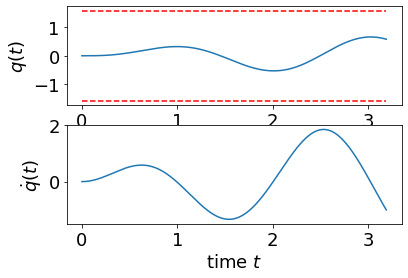

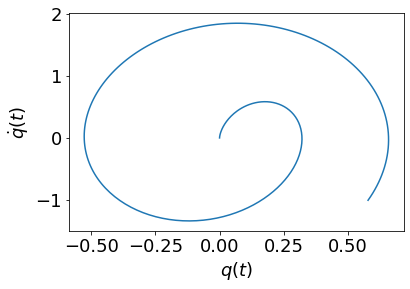

In [0]:
t = 10*np.sqrt(l/g)
dt = 1e-2

# non-zero initial state
q0 = 0
dq0 = 0
x0 = np.array([q0,dq0])

u = lambda t : .25*m*g*np.sin(np.sqrt(g/l)*t)

t_,x_ = numerical_simulation(f,t,x0,ut=u,dt=dt)

q_,dq_ = x_[:,0],x_[:,1]

# plot theta
plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,q_)
plt.plot(t_,+(np.pi/2)*np.ones_like(t_),'r--')
plt.plot(t_,-(np.pi/2)*np.ones_like(t_),'r--')
plt.ylabel(r'$q(t)$')

# plot dtheta
plt.subplot(2,1,2)
plt.plot(t_,dq_)
plt.ylabel(r'$\dot{q}(t)$')
plt.xlabel(r'time $t$')

# phase portrait
plt.figure()
plt.subplot(1,1,1)
plt.plot(q_,dq_)
plt.ylabel(r'$\dot{q}(t)$')
plt.xlabel(r'${q}(t)$')

print()

## predator/prey

Letting
$L(t)$ 
denote number of lynxes (predators)
and
$H(t)$ 
denote number of hares (prey),
the population dynamics are
$$\dot{H} = r H \left( 1 - \frac{H}{k} \right) - \frac{a H L}{c + H},\ H \ge 0,$$
$$\dot{L} = b \frac{a H L}{c + H} - d L,\ L \ge 0,$$
where:
* $r$ is growth rate of hares,
* $k$ is maximum hare population (in absence of lynxes),
* $a$ is consumption rate of hares as lynx population increases,
* $c$ limits prey consumption rate at low population,
* $b$ is grown coefficient of lynxes,
* $d$ is mortality rate of lynxes.

In [0]:
# use symbolic algebra to find equilibria
r,k,a,c,b,d = sym.symbols(r'r,k,a,c,b,d')
t,H,L = sym.symbols(r't,H,L')

dH = r * H * (1 - H / k) - a * H * L / (c + H)
dL = b * a * H * L / (c + H) - d * L

eqs = [dict(zip([H,L],eq)) for eq in sym.simplify(sym.solve([dH,dL],[H,L]))]
print(eqs)

[{H: 0, L: 0}, {H: k, L: 0}, {H: c*d/(a*b - d), L: -b*c*r*(-a*b*k + c*d + d*k)/(k*(a*b - d)**2)}]


We find three equilibria:
$$(H^*,L^*) = (0,0),\ (H^*,L^*) = (k,0),$$
$$(H^*,L^*) = \left(\frac{c d}{a b - d}, \frac{b c r (a b k - c d - d k)}{k (a b - d)^2}\right)$$
The first two correspond to the uninteresting / ecologically undesirable situation where there are no predators (and possibly no prey), so we'll focus on the third.

In [0]:
eq = eqs[2]

p = {a:3.2, b:0.6, c:50, d:0.56, k:125, r:1.6}

x = (H,L)
dx = sym.Matrix([dH,dL])

f = sym.lambdify((t,x),dx.subs(p))

(-5.0, 105.0)

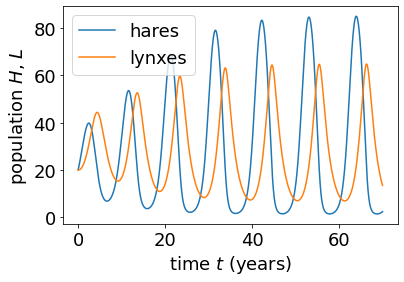

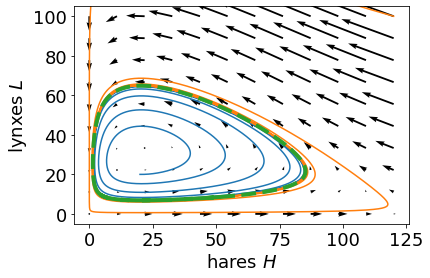

In [0]:

t = 70. # sec; simulation duration

x0 = np.asarray([20,20])

t_,x_ = numerical_simulation(lambda t,x : f(t,x).flatten(),t,x0,dt=1e-2)

H_,L_ = x_.T

# time trajectory
plt.figure()

ax = plt.subplot(1,1,1)
ax.plot(t_,H_,label='hares')
ax.plot(t_,L_,label='lynxes')
ax.legend()
ax.set_ylabel(r'population $H$, $L$')
ax.set_xlabel(r'time $t$ (years)')


# phase portrait / "quiver" plot
plt.figure()

H, L = np.meshgrid(np.linspace(0, 120, 12), np.linspace(0, 100, 10))
dH,dL = np.asarray([f(0.,(h,l)).flatten() for h,l in zip(H.flatten(),L.flatten())]).T
dH,dL = dH.reshape(H.shape),dL.reshape(L.shape)

ax = plt.subplot(1,1,1)
ax.plot(H_,L_)
ax.set_xlabel(r'hares $H$')
ax.set_ylabel(r'lynxes $L$')
ax.quiver(H,L,dH,dL)
ylim = ax.get_ylim()

x0 = np.asarray([120,100])
t_,x_ = numerical_simulation(lambda t,x : f(t,x).flatten(),t,x0,dt=1e-2)
H_,L_ = x_.T
ax.plot(H_,L_)
ax.plot(H_[-t_.size//5:],L_[-t_.size//5:],'--',lw=4)
ax.set_ylim(ylim)


## RLC circuit

Consider the following differential equation (DE) model of a series RLC circuit
$$ L \ddot{q} + R \dot{q} + q/C = u $$
where $q$ denotes the charge on the capacitor,
($R$, $L$, $C$) denote the (resistor, inductor, capacitor) parameters,
and $u$ denotes a series voltage source.

Letting $x = (q,\dot{q})\in\mathbb{R}^2$ denote the state of the circuit, we can rewrite (DE) in state-space form as $\dot{x} = f(x,u)$ where

$$\dot{x} = \frac{d}{dt}\left[\begin{array}{c} q \\ \dot{q} \end{array}\right] = \left[\begin{array}{c} \dot{q} \\ (-R\dot{q} - q/C + u)/L \end{array}\right] = f((q,\dot{q}),u) = f(x,u).$$

To simulate the circuit, we first implement a Python version of the state-space model; it'll be computationally expedient if $f$ accepts $t$, $x$, and $u$ as arguments even though mathematically it doesn't vary with $t$:

In [0]:
R,L,C = 1.,1.,1. # Ohm, Henry, Farad

def f(t,x,u):
    q,dq = x[0],x[1] # charge, current
    return np.hstack([dq,(-R*dq - q/C + u)/L])

Let's simulate the result of applying a sinusoidal voltage input and plot the result:

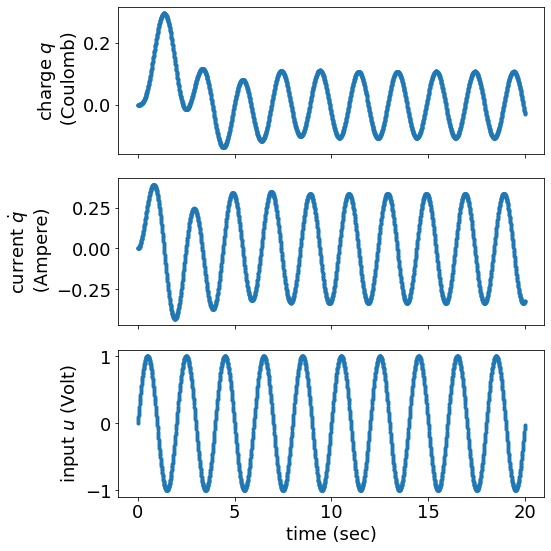

In [0]:
dt = 1e-2 # coarse timestep
freq = .5 # one cycle every two seconds
t = 10/freq # ten periods
x0 = np.hstack((0.,0.)) # no initial charge or current

# input is a periodic function of time
ut = lambda t : np.sin(2*np.pi*t*freq)
# lambda is a shorthand way to define a function
# -- equivalently:
def ut(t):
    return np.sin(2*np.pi*t*freq)

t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=ut)
u_ = np.array([ut(t) for t in t_])
# sim() returns arrays t_ and x_
# x_[j] is the state of the system (i.e. charge and current) at time t_[j]

fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,x_[:,0],'.-')
ax.set_xticklabels([])
ax.set_ylabel(r'charge $q$'+'\n (Coulomb)')

ax = plt.subplot(312)
ax.plot(t_,x_[:,1],'.-')
ax.set_xticklabels([])
ax.set_ylabel(r'current $\dot{q}$'+'\n (Ampere)')

ax = plt.subplot(313)
ax.plot(t_,u_,'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('input $u$ (Volt)')

plt.tight_layout()

So applying a sinusoidal input yielded sinusoidal fluctuations in charge and current -- this is unsurprising, since we know the circuit is actually linear.

Let's look at the linear frequency-domain model, i.e. the transfer function, which we can easily determine from the circuit's differential equation (DE) as
$$ G(s) = \frac{1}{L s^2 + R s + 1/C}. $$
To visualize how the circuit transforms signals in the frequency domain, we can create the ***Bode plot***, that is, we can plot the magnitude $|G(j\omega)|$ and angle $\angle G(j\omega)$ versus frequency $\omega$; these two plots directly tell us how a sinusoidal input at frequency $\omega$ is scaled and phase-shifted by the circuit.

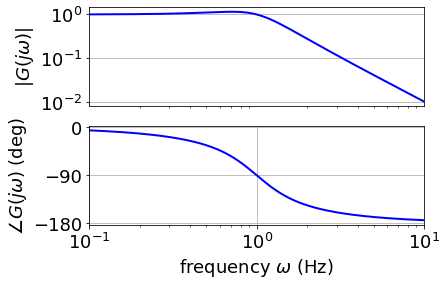

In [0]:
G = lambda s : 1. / (L*s**2 + R*s + 1/C)

omega = np.logspace(-1,1,1000)
xlim = omega[[0,-1]]

abs_G = np.abs(G(1.j*omega))
angle_G = np.unwrap(np.angle(G(1.j*omega)))*180./np.pi

plt.figure(); axs = []
ax = plt.subplot(2,1,1); ax.grid(True)
ax.loglog(omega,abs_G,'b-',lw=2)
ax.set_ylabel(r'$|G(j\omega)|$')
ax.set_yticks([10**-2,10**-1,10**0])
ax.set_xticks([])
ax.set_xlim(xlim)
axs.append(ax)

ax = plt.subplot(2,1,2); ax.grid(True)
ax.semilogx(omega,angle_G,'b-',lw=2)
ax.set_xlabel(r'frequency $\omega$ (Hz)')
ax.set_ylabel(r'$\angle G(j\omega)$ (deg)')
ax.set_yticks([0,-90,-180])
ax.set_xlim(xlim)
axs.append(ax)

Now let's visualize trajectories in the ***phase space***, that is, the $(q,\dot{q})$ plane.  We'll include a plot of one trajectory versus time since that's the way we're accustomed to looking at them, and we'll highlight that trajectory (in blue) on the ***phase portrait***.

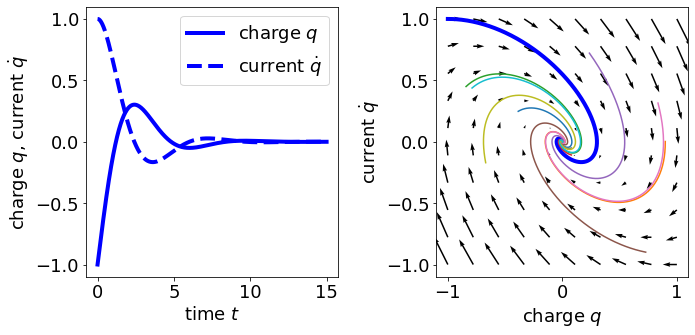

In [0]:
plt.figure(figsize=(10,5))

# initial condition
q0,dq0 = (-1.,1.)
x0 = np.array([q0,dq0])

# simulation time
t = 15

t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=lambda t : 0)
q_,dq_ = x_[:,0],x_[:,1]

# state vs time
ax = plt.subplot(1,2,1)
ax.set_xlabel(r'time $t$')
ax.set_ylabel(r'charge $q$, current $\dot{q}$')
plt.plot(t_,q_,'b',lw=4,label='charge $q$')
plt.plot(t_,dq_,'b--',lw=4,label='current $\dot{q}$')
plt.legend()

# phase portrait / "quiver" plot
ax = plt.subplot(1,2,2)
Q, Qd = np.meshgrid(np.linspace(-1,+1, 10), np.linspace(-1, +1, 10))
dQ,dQd = np.asarray([f(0.,(q,dq),0.).flatten() for q,dq in zip(Q.flatten(),Qd.flatten())]).T
dQ,dQd = dQ.reshape(dQ.shape),dQd.reshape(Qd.shape)
ax.quiver(Q,Qd,dQ,dQd)
ax.set_xlabel(r'charge $q$')
ax.set_ylabel(r'current $\dot{q}$')
ax.plot(q_,dq_,'b',lw=4)

for _ in range(10):
  # random initial condition in [-1,+1] x [-1,+1] square
  x0 = 2*(np.random.rand(2) - .5)
  t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=lambda t : 0)
  q_,dq_ = x_[:,0],x_[:,1]
  ax.plot(q_,dq_)
  

plt.tight_layout()

If we want a linear state-space model, it would be straightforward to analytically determine $A$ and $B$ such that $f(x,u) = A x + B u$ from the above equation, but if we only need a numerical answer we can let the computer determine them for us.

In [0]:
A = Jacobian(lambda x : f(0.,x,0.),x0)
B = Jacobian(lambda u : f(0.,x,u),[0.])

x = np.random.randn(2,1)
u = np.random.randn(1)

# these two ways of evaluating f do not yield exactly the same floats
# so this simple comparison will return False
# f(0.,x,u) == (A @ x + B * u).flatten()

print('f(x,u) differs from A x + B u by %0.2e'%
      np.max(np.abs(f(0.,x,u) - (A @ x + B * u).flatten())))

# instead, we use NumPy's "allclose" function, which tolerates small errors
assert np.allclose(f(0.,x,u), (A @ x + B * u).flatten())

f(x,u) differs from A x + B u by 1.03e-13


## quadrotor

Consider the simplified vertical-plane quadrotor model
$$ M\ddot{\eta} = F\sin\theta, $$
$$ M\ddot{\nu} = -Mg + F\cos\theta, $$
$$ I\ddot{\theta} = \tau $$
where ($\eta$, $\nu$) denote the quadrotor (horizontal, vertical) position and $\theta$ denotes the quadrotor's rotation, ($M$, $I$) denote quadrotor (mass, inertia), $g$ is acceleration due to gravity, and ($F$, $\tau$) denote the net (thrust, torque) applied by the spinning rotors.

With $q = (\eta,\nu,\theta)\in\mathbb{R}^3$ denoting positions and $\dot{q} = \frac{d\ }{dt} q = (\dot{\eta},\dot{\nu},\dot{\theta})\in\mathbb{R}^3$ denoting velocities,
the state vector is $x = (q,\dot{q})\in\mathbb{R}^6$,
the input vector is $u = (F,\tau)\in\mathbb{R}^2$,
and the state-space model is
$$ \dot{x} = \frac{d}{dt}\left[\begin{array}{c} q \\ \dot{q} \end{array}\right] = \left[\begin{array}{c} \dot{q} \\ \ddot{q}(x,u) \end{array}\right] = f(x,u), $$
where $\ddot{q} : \mathbb{R}^6 \times \mathbb{R}^2 \rightarrow \mathbb{R}^3$ is defined by 
$$\ddot{q}(x,u) = \left[\begin{array}{c} \frac{F}{M}\sin\theta \\ -g + \frac{F}{M}\cos\theta \\ \frac{\tau}{I}\end{array}\right].$$ 

    [1]: http://dx.doi.org/10.1109/ROBOT.2010.5509452

To simulate the pendulum, we first implement Python versions of the ODE control system model; it'll be computationally expedient if both $f$ and $h$ accept $t$, $x$, and $u$ as arguments even though mathematically they may not depend on all three:

In [0]:
g,M,I = 9.81,1.,1. # m/sec^2, kg, kg m^2

def f(t,x,u):
    q,dq = x[:3],x[3:] # positions, velocities
    eta,nu,theta = q # horiz., vert., rotation
    F,tau = u # thrust, torque
    return np.hstack([dq,(F/M)*np.sin(theta),
                        -g + (F/M)*np.cos(theta),
                        tau/I])

Note that $\dot{q}_0 = 0$ (i.e. zero velocity) is an equilibrium with any position $q$ when input $u = (Mg,0)$ (i.e. zero torque and thrust $Mg$) is applied:

In [0]:
q0 = np.array([0.,1.,0.])
dq0 = np.array([0.,0.,0.])
x0 = np.hstack((q0,dq0))
u0 = np.array([M*g,0.])
print('x0 =',x0,'\nf(x0) =',f(0.,x0,u0))

x0 = [0. 1. 0. 0. 0. 0.] 
f(x0) = [0. 0. 0. 0. 0. 0.]


Let's simulate the result of applying a sinusoidal thrust, and plot/animate the result:

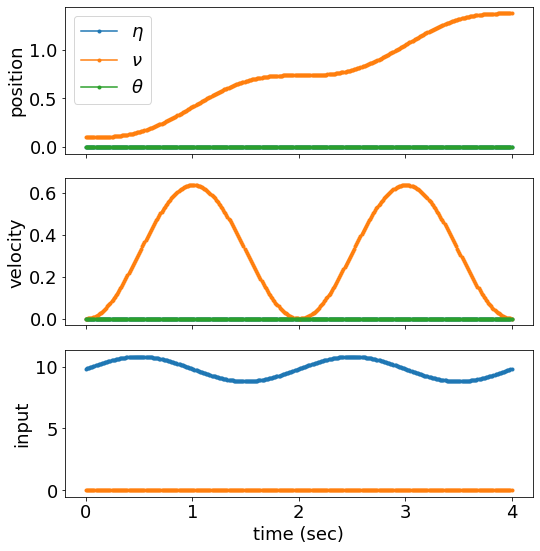

In [0]:
dt = 1e-2 # coarse timestep
freq = .5 # one cycle every two seconds
t = 2./freq # two periods
q = [0.,.1,0.] # start 10cm up off the ground
dq = [0.,0.,0.] # start with zero velocity
x = np.hstack((q,dq))

# input is a periodic function of time
ut = lambda t : np.array([M*g + np.sin(2*np.pi*t*freq),0.])
# lambda is a shorthand way to define a function
# -- equivalently:
def u(t):
    return np.array([M*g + np.sin(2*np.pi*t*freq),0.])

sim = numerical_simulation
t_,x_ = sim(f,t,x,dt=dt,ut=ut)
u_ = np.array([u(t) for t in t_])
# sim() returns arrays t_ and x_
# x_[j] is the state of the system (i.e. pos. and vel.) at time t_[j]

fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,x_[:,:3],'.-')
ax.set_xticklabels([])
ax.set_ylabel('position')
ax.legend([r'$\eta$',r'$\nu$',r'$\theta$'],ncol=1,loc='upper left')

ax = plt.subplot(312)
ax.plot(t_,x_[:,3:],'.-')
ax.set_xticklabels([])
ax.set_ylabel('velocity')

ax = plt.subplot(313)
ax.plot(t_,u_,'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('input')

plt.tight_layout();

In [0]:
fig, ax = plt.subplots(figsize=(6,6)); ax.axis('equal'); ax.grid(True);

line, = ax.plot([], [], 'b', lw=2);

plt.close(fig)

# initialization -- called once
def init():
  gndh,gndv = [-10.,10.,10.,-10.],[0.,0.,-5.,-.5]
  ax.fill(gndh,gndv,'gray')
  line.set_data([], [])
  ax.set_xlim(( -1., 1.))
  ax.set_ylim(( -.15, 2.))
  ax.set_xlabel(r'horiz. pos. $\eta$')
  ax.set_ylabel(r'vert. pos. $\nu$')
  #plt.tight_layout()
  return (line,)

# animation -- called iteratively
def animate(t):
  j = (t_ >= t).nonzero()[0][0]
  h,v,th = x_[j,:3]
  w = .25
  x = np.array([-w/2.,w/2.,np.nan,0.,0.])
  y = np.array([0.,0.,np.nan,0.,+w/3.])
  z = (x + 1.j*y)*np.exp(1.j*th) + (h + 1.j*v)
  line.set_data(z.real, z.imag)
  return (line,)

# call the animator
animation.FuncAnimation(fig, animate, init_func=init, repeat=True,
                      frames=np.arange(0.,t_[-1],.05), interval=50, blit=True)

To stabilize the quadrotor, we'll linearize the DE (i.e. take the derivative of the function $f$):

In [0]:
A = Jacobian(lambda x : f(0.,x,u0),x)
B = Jacobian(lambda u : f(0.,x,u),u0)

print('A =\n',A,'\n','B =\n',B)

A =
 [[0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   1.  ]
 [0.   0.   9.81 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]] 
 B =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]]


In [0]:
K_random = np.random.randn(2,6)

roots = np.array([-1.502+3.62j , -1.502-3.62j , -1.498+0.627j, -1.498-0.627j, -1.5  +1.5j  , -1.5  -1.5j  ])
K_stable = np.asarray(ctrl.place(A,B,roots))

print("closed loop stable with K_random?",
      np.all(la.eigvals(A - np.dot(B,K_random)).real < 0))

print("closed loop stable with K_stable?",
      np.all(la.eigvals(A - np.dot(B,K_stable)).real < 0))

closed loop stable with K_random? False
closed loop stable with K_stable? True


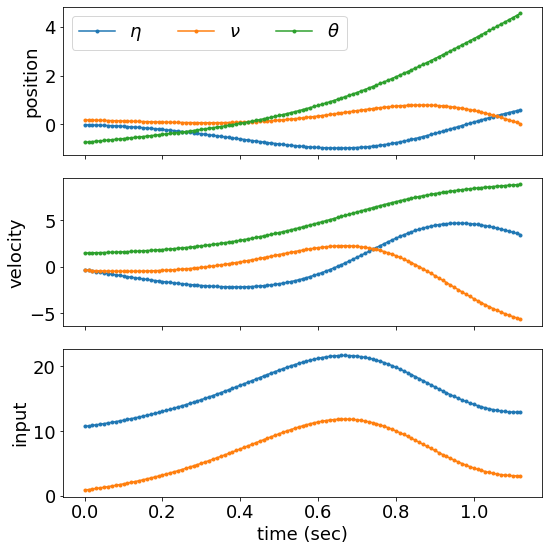

In [0]:
np.random.seed(50)

dt = 1e-2
t = 3. 
x = x0 + 3*(np.random.rand(6)-.5)

K_random = np.random.randn(6)

# destabilizing controller
K = K_random

# input is now a function of state
ux = lambda x : np.dot(x - x0, -K.T) + u0

t_,x_ = sim(f,t,x,dt=dt,ux=ux)

# quadrotor height
v = x_[:,1]
# if quadrotor crashed
if np.any(v < 0):
  # find when it crashed
  k = np.argmax(v < 0)
  # terminate simulation at crash
  t_ = t_[:k]
  x_ = x_[:k]

u_ = np.array([ux(x) for x in x_])

fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,x_[:,:3],'.-')
ax.set_xticklabels([])
ax.set_ylabel('position')
ax.legend([r'$\eta$',r'$\nu$',r'$\theta$'],ncol=3,loc='upper left')

ax = plt.subplot(312)
ax.plot(t_,x_[:,3:],'.-')
ax.set_xticklabels([])
ax.set_ylabel('velocity')

ax = plt.subplot(313)
ax.plot(t_,u_,'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('input')

plt.tight_layout();

In [0]:
fig, ax = plt.subplots(figsize=(6,6)); ax.axis('equal'); ax.grid(True);

line, = ax.plot([], [], 'b', lw=2);

plt.close(fig)

# call the animator
animation.FuncAnimation(fig, animate, init_func=init, repeat=True,
                  frames=np.arange(0.,t_[-1],.01), interval=20, blit=True)

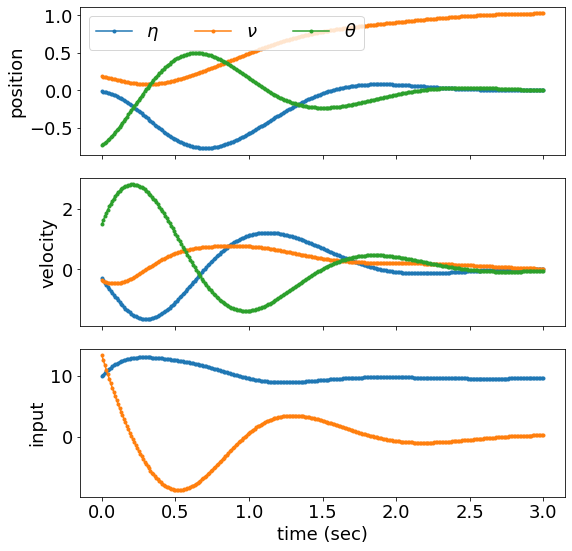

In [0]:
np.random.seed(50)

dt = 1e-2
t = 3. 
x = x0 + 3*(np.random.rand(6)-.5)

# stabilizing controller
K = K_stable

# input is now a function of state
ux = lambda x : np.dot(x - x0, -K.T) + u0

t_,x_ = sim(f,t,x,dt=dt,ux=ux)

# quadrotor height
v = x_[:,1]

u_ = np.array([ux(x) for x in x_])

fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,x_[:,:3],'.-')
ax.set_xticklabels([])
ax.set_ylabel('position')
ax.legend([r'$\eta$',r'$\nu$',r'$\theta$'],ncol=3,loc='upper left')

ax = plt.subplot(312)
ax.plot(t_,x_[:,3:],'.-')
ax.set_xticklabels([])
ax.set_ylabel('velocity')

ax = plt.subplot(313)
ax.plot(t_,u_,'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('input')

plt.tight_layout();

In [0]:
fig, ax = plt.subplots(figsize=(6,6)); ax.axis('equal'); ax.grid(True);

line, = ax.plot([], [], 'b', lw=2);

plt.close(fig)

# call the animator
animation.FuncAnimation(fig, animate, init_func=init, repeat=True,
                  frames=np.arange(0.,t_[-1],.01), interval=20, blit=True)

# closing the loop -- time domain

## nonlinear system (NL)

Consider the following nonlinear model for a massless rigid rod of length $\ell$ wherein one end is affixed to a point mass $m$ and the other end is affixed to a pin joint that applies a frictional force with constant $\gamma$ and actuator torque $\tau$,

$$ m \ell^2 \ddot{\theta} = m g \ell \sin\theta - \gamma\dot{\theta} + \ell \tau \cos\theta. $$

An onboard camera measures the horizontal position of the mass, scaled by the length of the rod.

We'll use parameter values $m = 1\ \text{kg}$, $\ell = 0.25\ \text{m}$, $g = 9.81\ \text{m/sec}^2$, $\gamma = 0.1$.

In [0]:
m = 1. # == 1.0 =! 1 
l = 0.25
g = 9.81
gamma = 0.1

With $x = (\theta,\dot{\theta})\in\mathbb{R}^2$ denoting the state vector, $u = \tau \in\mathbb{R}$ denoting the input, and $y = \ell\sin\theta\in\mathbb{R}$ denoting the output, the nonlinear control system model is given by

$$\dot{x} = \left[\begin{matrix}\dot{\theta} \\ \ddot{\theta}\end{matrix}\right] = \left[\begin{matrix} x_2\\ \frac{1}{m\ell^2}\left(mg\ell\sin x_1-\gamma x_2+u\ell\cos x_1\right) \end{matrix}\right] = f(x,u), $$

$$ y = h(x,u) = \ell\sin x_1. $$



In [0]:
def f_NL(t,x,u):
  theta,dtheta = x # assumes x is iterable with len(x) == 2
  ddtheta = (m*g*l*np.sin(theta) - gamma*dtheta + l*u*np.cos(theta)) / (m*l**2)
  return np.hstack([dtheta,ddtheta])

def h_NL(t,x,u):
  theta,dtheta = x 
  return np.array([l*np.sin(theta)])

### equilibrium

With no applied torque ($u_e = 0$), this system has an equilibrium at $x_e = (\theta_e,\dot{\theta}_e) = (k\pi,0)$ for every integer $k\in\mathbb{Z} = \{0,+1,-1,+2,-2,\dots\}$ -- we'll focus on the equilibrium at the origin, i.e. $k = 0$.

In [0]:
th_e = 0.
dth_e = 0.

x_e = np.array([th_e,dth_e])
u_e = np.array([0.])

assert np.allclose(0.,f_NL(0.,x_e,u_e))

Note that we use `np.allclose` to confirm that `(x_e,u_e)` is an equilibrium since `==` is too stringent for comparing floating-point numbers.

Whereas this array really does appear to be "zero" ...

In [0]:
f_NL(0.,x_e,u_e)

array([0., 0.])

... even tiny discrepancies in the sixth decimal place will be detected by `==`.

In [0]:
assert 1.000001 == 1

AssertionError: ignored

## linearized system (LTI)

Linearizing this nonlinear system about the equilibrium $x_e = (\theta_e,\dot{\theta}_e) = (0,0)$ yields

$$ \dot{\xi} = A \xi + B \mu,\ \eta = C \xi + D \mu, $$

where

$$	A = \left[\begin{matrix} 0 & 1\\ \frac{g}{\ell} & -\frac{\gamma}{m\ell^2} \end{matrix}\right],\ B =\left[\begin{matrix} 0\\ \frac{1}{m\ell} \end{matrix}\right],\ C = \left[\begin{matrix} \ell & 0 \end{matrix}\right],\ D = 0, $$

and $x \approx x_e + \xi$, $y \approx y_e + \eta$ when $u = u_e + \mu$, where $u_e = 0$ and $y_e = h(x_e,u_e) = 0$.

In [0]:
A = np.array([[0,   1],
              [g/l, -gamma/(m*l**2)]])

B = np.array([[0],
              [1/(m*l)]])

C = np.array([[l,0]])

D = np.array([[0]])

To check that we've computed the Jacobian derivatives correctly, we can numerically approximate the derivative using finite differences:

$$ A_{jk} = \left.\frac{\partial  f_j}{\partial x_k}\right|_{(x_e,u_e)} = \lim_{\Delta\rightarrow 0} \frac{1}{\Delta} \left(f_j(x_e + \Delta e_k,u_e) - f_j(x_e,u_e)\right) \approx \frac{1}{\Delta} \left(f_j(x_e + \Delta e_k,u_e) - f_j(x_e,u_e)\right) $$

where $e_k = (0,\dots,0,1,0,\dots,0)^\top$ is the $k$-th standard (Euclidean) basis vector, i.e. it's a vector of all zeros *except* a one (1) in the $k$-th entry.

In [0]:
assert np.allclose(A, Jacobian(lambda x : f_NL(0.,x,u_e),x_e,1e-3))

assert np.allclose(B, Jacobian(lambda u : f_NL(0.,x_e,u),u_e))

assert np.allclose(C, Jacobian(lambda x : h_NL(0.,x,u_e),x_e))

assert np.allclose(D, Jacobian(lambda u : h_NL(0.,x_e,u),u_e))

### stability

In [0]:
print('eigenvalues of A =',la.eigvals(A))

eigenvalues of A = [ 5.515+0.j -7.115+0.j]


Since one eigenvalue is in the right half-plane, the equilibrium is *unstable*.

In [0]:
Re_eigvals = np.real(la.eigvals(A))

if np.any(Re_eigvals > 0):
  print('A is *unstable*')
  
elif np.all(Re_eigvals < 0):
  print('A is *asymptotically stable*')
  
else:
  print('A is *neutrally stable*')

A is *unstable*


### controller design

Let's choose controller gains that place the eigenvalues of the closed-loop system at $-\sigma \pm j\omega$ where $\sigma,\omega > 0$.  Note that this is equivalent to choosing gains to ensure the desired characteristic polynomial is

$$ p(s) = s^2 + 2\sigma s + (\sigma^2 + \omega^2). $$

The closed-loop characteristic polynomial $\operatorname{det}(sI - (A - BK))$ is 

$$ s^2 + s\left(\frac{\gamma}{m\ell^2} + \frac{k_2}{m\ell}\right) + \left( \frac{k_1}{m\ell} - \frac{g}{\ell}\right), $$

whence we should choose 

$$ k_1 = m\ell(\sigma^2 + \omega^2) + mg,\ k_2=2m\ell\sigma-\frac{\gamma}{\ell} $$

to ensure $\operatorname{det}(sI - (A - BK)) = p(s)$, i.e. the closed-loop eigenvalues are $\lambda(A - BK) = -\sigma \pm j\omega$ as desired.

In [0]:
sigma = 1.
omega = 0.25

k1 = m*l*(sigma**2 + omega**2) + m*g
k2 = 2*m*l*sigma - gamma/l

K = np.array([[k1,k2]])

print('eigenvalues of (A - BK) =',la.eigvals(A - np.dot(B,K)))

eigenvalues of (A - BK) = [-1.+0.25j -1.-0.25j]


In [0]:
print('matching coefficients yields K =',K)
print('      ctrl.place(...) yields K =',ctrl.place(A,B,[-sigma+1.j*omega,
                                                         -sigma-1.j*omega]))

matching coefficients yields K = [[10.076  0.1  ]]
      ctrl.place(...) yields K = [[10.076  0.1  ]]


Let's simulate the system to evaluate the performance.

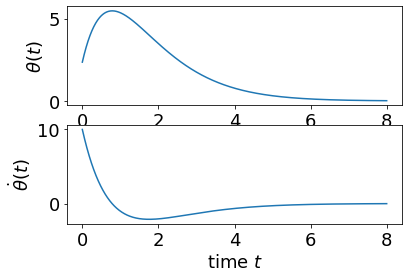

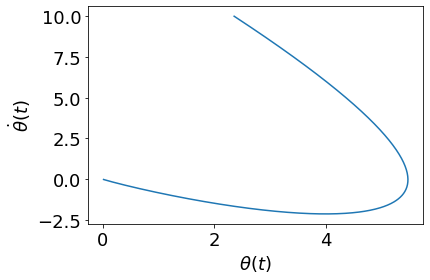

In [0]:
def f_LTI(t,x,u):
  # x is a 1-D array, i.e. a "row", so we left-multiply the transpose of (A-BK)
  return np.dot(x,(A-np.dot(B,K)).T)

# simulation duration, timestep
T = 8.
dt = 1e-2

# non-zero initial state
theta0 = 3*np.pi/4
dtheta0 = 10.
x0 = np.array([theta0,dtheta0])

# zero input
def u(t):
  ut = 0
  return ut
# this could equivalently be written in one line:
# u = lambda t : 0.

# numerical simulation returns:
# t_ - size N array
# x_ - size N x 2 array (since the state is 2-dimensional)
t_,x_ = numerical_simulation(f_LTI,T,x0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
theta_,dtheta_ = x_[:,0],x_[:,1]

# we'll use the Matplotlib library for plots
# (as the name suggests, it has a similar interface to MATLAB)
import pylab as plt

# plot theta
plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,theta_,label='(Linear)')
plt.ylabel(r'$\theta(t)$')

# plot dtheta
plt.subplot(2,1,2)
plt.plot(t_,dtheta_,label='(Linear)')
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'time $t$')

# phase portrait
plt.figure()
plt.subplot(1,1,1)
plt.plot(theta_,dtheta_,label='(Linear)')
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'${\theta}(t)$')

print()

### observer design

Let's choose observer gains that place the eigenvalues of the error dynamics at $-\zeta < 0$.  This time we'll rely on the *ctrl.place(...)* function to do the work for us.

In [0]:
zeta = 5*sigma

poles = [-zeta,-zeta-1e-6]

L = np.array(ctrl.place(A.T,C.T,poles).T)

print('ctrl.place(...) yields L.T =',L.flatten())

print('eigenvalues of (A - LC) =',la.eigvals(A - np.dot(L,C)))

ctrl.place(...) yields L.T = [ 33.6 203.2]
eigenvalues of (A - LC) = [-5.+0.j -5.+0.j]


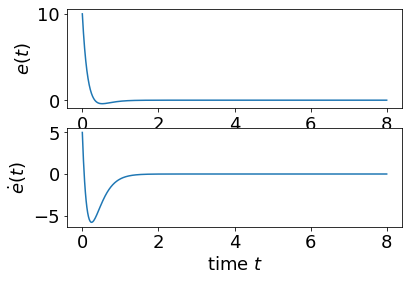

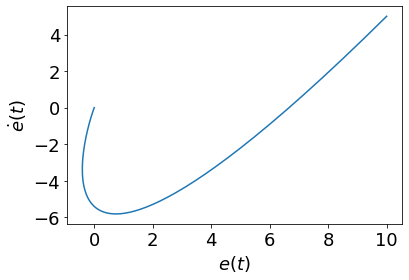

In [0]:
# vector field
def f_error(t,e,u):
  # x is a 1-D array, i.e. a "row", so we left-multiply the transpose of (A-LC)
  return np.dot(e,(A-np.dot(L,C)).T)

# non-zero initial state
error0 = 10.
derror0 = 5.
e0 = np.array([error0,derror0])

# zero input
def u(t):
  ut = 0
  return ut
# this could equivalently be written in one line:
# u = lambda t : np.sin(t)

# numerical simulation returns:
# t_ - size N array
# e_ - size N x 2 array (since the state is 2-dimensional)
t_,e_ = numerical_simulation(f_error,T,e0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
error_,derror_ = e_[:,0],e_[:,1]

# we'll use the Matplotlib library for plots
# (as the name suggests, it has a similar interface to MATLAB)
import pylab as plt

# plot theta
plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,error_,label='(Linear)')
plt.ylabel(r'$e(t)$')

# plot dtheta
plt.subplot(2,1,2)
plt.plot(t_,derror_,label='(Linear)')
plt.ylabel(r'$\dot{e}(t)$')
plt.xlabel(r'time $t$')

# phase portrait
plt.figure()
plt.subplot(1,1,1)
plt.plot(error_,derror_,label='(Linear)')
plt.ylabel(r'$\dot{e}(t)$')
plt.xlabel(r'$e(t)$');

### closing the loop

When we close the loop through an observer system, the time derivative of the controlled system state $x$ and the observer system state $\widehat{x}$ are coupled to each other through the control input $u = - K \widehat{x}$ and output error $y - \widehat{y}$.  Thus, we need to implement a simulation of the *augmented* system with state $z = (x,\widehat{x})$:

$$ \dot{z} = \left[\begin{matrix} \dot{x} \\ \dot{\widehat{x}} \end{matrix}\right] = \left[\begin{matrix} A x - B K \widehat{x} \\ A \widehat{x} - B K \widehat{x} + L(y - \widehat{y}) \end{matrix}\right],\ y = C x - D K \widehat{x},\ \widehat{y} = C \widehat{x} - D K \widehat{x} $$

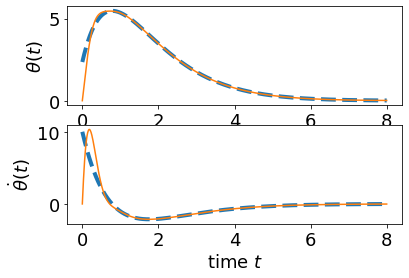

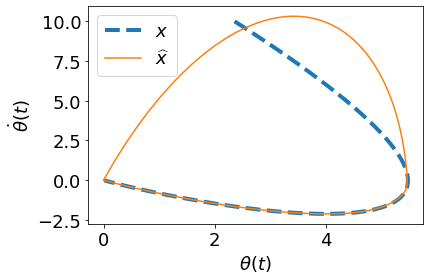

In [0]:
# closed-loop vector field
def f_cl(t,z,u): 
  
  # extract controlled system and observer system state from full system state
  x,x_hat = z[:2],z[2:] # equivalent to z[0:2],z[2:-1]
  
  # compute control input using observer state
  u = -np.dot(x_hat,K.T)
  
  # output from controlled system and observer system
  y = np.dot(x,C.T) + np.dot(u,D.T)
  y_hat = np.dot(x_hat,C.T) + np.dot(u,D.T)
  
  # dynamics of controlled system and observer system
  dx = f_LTI(t,x,u)
  dx_hat = np.dot(x_hat,A.T) + np.dot(u,B.T) + np.dot((y-y_hat),L.T)
  
  # combine dynamics of controlled system and observer system
  dz = np.hstack((dx,dx_hat))

  return dz

theta0_hat = 0.
dtheta0_hat = 0.

# non-zero initial state
z0 = np.array([theta0, dtheta0, theta0_hat, dtheta0_hat])

# zero input
def u(t):
  ut = 0
  return ut
# this could equivalently be written in one line:
# u = lambda t : np.sin(t)

# numerical simulation returns:
# t_ - size N array
# z_ - size N x 2 array (since the state is 2-dimensional)
t_,z_ = numerical_simulation(f_cl,T,z0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
x_ = z_[:,:2]
x_hat_ = z_[:,2:]
theta_,dtheta_, = x_.T
theta_hat_,dtheta_hat_, = x_hat_.T

# we'll use the Matplotlib library for plots
# (as the name suggests, it has a similar interface to MATLAB)
import pylab as plt
plt.figure()

# plot theta, theta_hat
plt.subplot(2,1,1)
plt.plot(t_,theta_,'--',lw=4,label=r'$\theta$')
plt.plot(t_,theta_hat_,label=r'$\widehat{\theta}$')
plt.ylabel(r'$\theta(t)$')

# plot dtheta, dtheta_hat
plt.subplot(2,1,2)
plt.plot(t_,dtheta_,'--',lw=4,label=r'$\dot{\theta}$')
plt.plot(t_,dtheta_hat_,label=r'$\dot{\widehat{\theta}}$')
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'time $t$')

plt.figure()
plt.subplot(1,1,1)
plt.plot(theta_,dtheta_,'--',lw=4,label=r'$x$')
plt.plot(theta_hat_,dtheta_hat_,label=r'$\widehat{x}$')
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'${\theta}(t)$')
plt.legend();

## nonlinear system (NL)

### closing the loop

$$ \dot{z} = \left[\begin{matrix} \dot{x} \\ \dot{\widehat{x}} \end{matrix}\right] = \left[\begin{matrix} f(x,-K\widehat{x}) \\ A \widehat{x} - B K \widehat{x} + L(y - \widehat{y}) \end{matrix}\right],\ \widehat{y} = C \widehat{x} - D K \widehat{x},\ y = h(x, -K\widehat{x}) $$

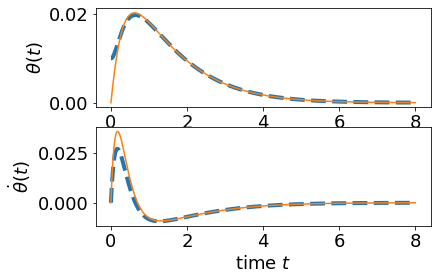

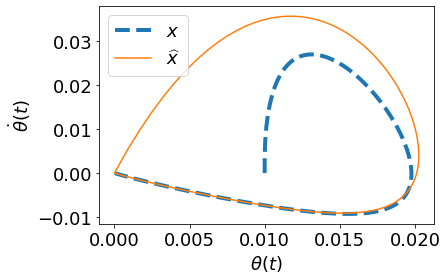

In [0]:
# vector field
def f_cl(t,z,u): 
  
  # extract controlled system and observer system state from full system state
  x,x_hat = z[:2],z[2:]
  
  # compute control input using observer state
  u = -np.dot(x_hat,K.T)
  
  # output from controlled system and observer system
  y = h_NL(t,x,u)
  y_hat = np.dot(x_hat,C.T) + np.dot(u,D.T)
  
  # dynamics of controlled system and observer system
  dx = f_NL(t,x,u)
  dx_hat = np.dot(x_hat,A.T) + np.dot(u,B.T) + np.dot((y-y_hat),L.T)
  
  # combine dynamics of controlled system and observer system
  dz = np.hstack((dx,dx_hat))

  return dz

# NOTE:  nonlinear system's initial state needs to be VERY close to x_e
theta0,dtheta0 = .01,.0

theta0_hat = 0.
dtheta0_hat = 0.

# non-zero initial state
z0 = np.array([theta0, dtheta0, theta0_hat, dtheta0_hat])

# zero input
def u(t):
  ut = 0
  return ut
# this could equivalently be written in one line:
# u = lambda t : np.sin(t)

# numerical simulation returns:
# t_ - size N array
# z_ - size N x 2 array (since the state is 2-dimensional)
t_,z_ = numerical_simulation(f_cl,T,z0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
x_ = z_[:,:2]
x_hat_ = z_[:,2:]
theta_,dtheta_, = x_.T
theta_hat_,dtheta_hat_, = x_hat_.T

# we'll use the Matplotlib library for plots
# (as the name suggests, it has a similar interface to MATLAB)
import pylab as plt
plt.figure()

# plot theta, theta_hat
plt.subplot(2,1,1)
plt.plot(t_,theta_,'--',lw=4,label=r'$\theta$')
plt.plot(t_,theta_hat_,label=r'$\widehat{\theta}$')
plt.ylabel(r'$\theta(t)$')

# plot dtheta, dtheta_hat
plt.subplot(2,1,2)
plt.plot(t_,dtheta_,'--',lw=4,label=r'$\dot{\theta}$')
plt.plot(t_,dtheta_hat_,label=r'$\dot{\widehat{\theta}}$')
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'time $t$')

plt.figure()
plt.subplot(1,1,1)
plt.plot(theta_,dtheta_,'--',lw=4,label=r'$x$')
plt.plot(theta_hat_,dtheta_hat_,label=r'$\widehat{x}$')
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'${\theta}(t)$')
plt.legend();

# closing the loop -- frequency domain

## Nyquist plot

The *Nyquist plot* of a transfer function $L(s)$ is the graph of $L(j\omega)$ in the complex plane:

$$ \Omega = \{ L(j\omega)\in\mathbb{C} : -\infty < \omega < \infty \} $$

For example, consider the third-order transfer function

$$ L(s) = \frac{1}{(s+a)^3} $$

with $a = 0.6$.

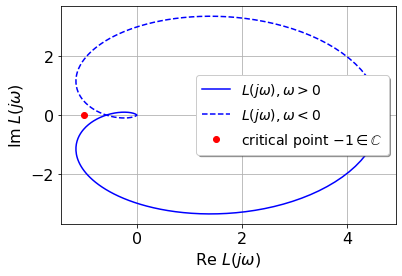

In [0]:
L = lambda s,a=0.6 : 1. / (s + a)**3

# equivalently:

def L(s,a=0.6):
  return 1. / (s + a)**3

omega = np.linspace(0.,1e1,1000)

Omega = L(1.j*omega)

plt.figure()
ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
ax.plot(-1.,0.,'ro',label=r'critical point $-1\in\mathbb{C}$')
ax.legend(fontsize=14,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

Since the graph $\Omega$ of $L(j\omega)$ does not of the *critical point* $-1\in\mathbb{C}$ (and no poles in the right half-plane), the *Nyquist stability criterion (simplified)* implies $\frac{L}{1 + L}$ has no poles in the right half-plane, i.e. is (asymptotically) *stable*.

## Bode and Nyquist plots

For example, consider the third-order transfer function

$$ L(s) = \frac{1}{s(s+1)^2}. $$

The *Bode plot* is the graph of $|L(j\omega)|$ and $\angle L(j\omega)$ as $\omega$ varies between $0$ and $+\infty$ (note that the graph is symmetric for negative $\omega$, so we omit this from the plot).

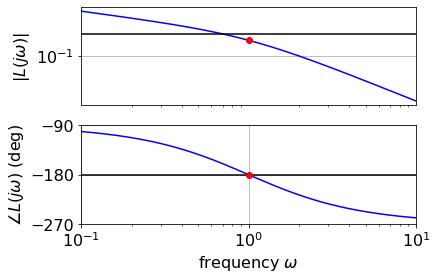

In [0]:
L = lambda s : 1. / (s * (s + 1)**2)

omega = np.logspace(-1,1,1000)
xlim = omega[[0,-1]]

abs_L = np.abs(L(1.j*omega))
angle_L = np.unwrap(np.angle(L(1.j*omega)))*180./np.pi

critical = (angle_L < -180).nonzero()[0][0]

plt.figure(); axs = []
ax = plt.subplot(2,1,1); ax.grid('on')
ax.loglog(omega,abs_L,'b-')
ax.loglog(xlim,[1.,1.],'k-')
ax.loglog(omega[critical],abs_L[critical],'ro')
ax.set_ylabel(r'$|L(j\omega)|$')
ax.set_xticks([])
ax.set_xlim(xlim)
axs.append(ax)

ax = plt.subplot(2,1,2); ax.grid('on')
ax.semilogx(omega,angle_L,'b-')
ax.semilogx(xlim,[-180.,-180.],'k-')
ax.semilogx(omega[critical],angle_L[critical],'ro')
ax.set_xlabel(r'frequency $\omega$')
ax.set_ylabel(r'$\angle L(j\omega)$ (deg)')
ax.set_yticks([-90,-180,-270])
ax.set_xlim(xlim)
axs.append(ax)

for ax in axs:
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
               ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(16)

Noting that this *Bode plot* simply displays values of $L(j\omega)$ in polar coordinates, it can be transcribed to obtain the *Nyquist plot* of $L(j\omega)$ in the complex plane $\mathbb{C}$:

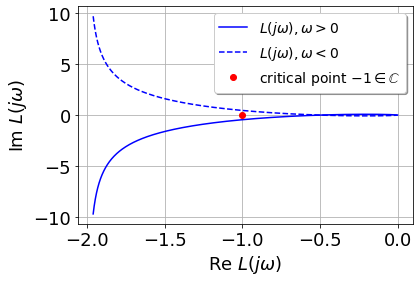

In [0]:
Omega = L(1.j*omega)

plt.figure()
ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
ax.plot(-1.,0.,'ro',label=r'critical point $-1\in\mathbb{C}$')
ax.legend(fontsize=14,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');

## effect of feedback gain

Note that scaling the transfer function by a constant *gain* $k > 0$ simply scales the *Nyquist plot* since

$$ \Omega_{k L} = \{ k L(j\omega) : -\infty < \omega < \infty \} = k \{ L(j\omega) : -\infty < \omega < \infty \} = k\, \Omega_L. $$

This implies that some systems can be stabilized by simply reducing the gain.

In more interesting situations, the system can be stabilized by *increasing* the gain -- consider the following transfer function [AMv2 Ex 10.5]:

$$ L(s) = \frac{3 (s+6)^2}{s(s+1)^2}. $$

The graph $\Omega_L$ has a complicated double--loop on the negative real axis:

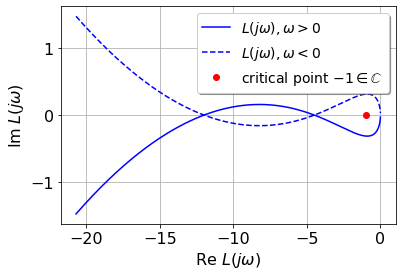

In [0]:
L = lambda s : (3*(s+6.)**2) / (s*(s+1)**2)

omega = np.logspace(0.2,2,1000)

Omega = L(1.j*omega)

plt.figure()
ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
ax.plot(-1.,0.,'ro',label=r'critical point $-1\in\mathbb{C}$')
ax.legend(fontsize=14,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

Note that there are *no (net) encirclements of the critical point $-1\in\mathbb{C}$*, so the *Nyquist stabitility criterion (simplified)* implies that the closed-loop transfer function $\frac{L}{1+L}$ is (asymptotically) *stable*!

Even more counter-intuitive:  the system will become *unstable* if we *decrease* the gain too much, i.e. scale $L$ down by a factor $0 < k < 1$ that is small enough so that the critical point becomes encircled:

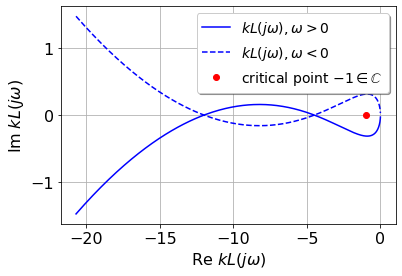

In [0]:
k = 1

Omega_k = k * L(1.j*omega)



plt.figure()
ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(Omega_k.real,Omega_k.imag,'b-',label=r'$k L(j\omega), \omega > 0$')
ax.plot(Omega_k.real,-Omega_k.imag,'b--',label=r'$k L(j\omega), \omega < 0$')
ax.plot(-1.,0.,'ro',label=r'critical point $-1\in\mathbb{C}$')
ax.legend(fontsize=14,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ k L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ k L(j\omega)$');

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

With $k = 0.125$, the graph of $k L(j\omega)$ encircles the critical point $-1$, so the closed-loop transfer function $\frac{L}{1+L}$ is *unstable*!

## stability margins

Above, we used the *Nyquist plot* to assess *stability* of a closed-loop system, but this plot can also be used to assess *robustness* of the closed-loop system.

There are three frequently-used robustness notions, termed *stability margins*, that we can determine from the *Nyquist plot*:

* *stability margin* $s_m$ = distance from $\Omega$ to $-1\in\mathbb{C}$;
* *gain margin* $g_m$ = smallest increase in gain that causes $\Omega$ to encircle $-1$ (computed as the inverse of distance from $\Omega$ to $-1\in\mathbb{C}$);
* *phase margin* $\varphi_m$ = smallest change in phase that causes $\Omega$ to encircle $-1$ (computed as the distance from $\Omega$ to $-1\in\mathbb{C}$ restricted to rotation of $\Omega$).

In [1]:
L = lambda s,a=0.6 : 1. / (s + a)**3

omega = np.linspace(0.75,1e1,1000)
Omega = L(1.j*omega)

abs_L = np.abs(Omega)
angle_L = np.unwrap(np.angle(Omega))*180./np.pi
angle_L = (np.angle(Omega))*180./np.pi

circle = np.exp(1.j*np.linspace(0.,2*np.pi))

# index (i.e. entry) of Omega array corresponding to stability margin
g_m_idx = (angle_L < -180).nonzero()[0][0]
phi_m_idx = np.argmin(np.min(np.abs(Omega - circle[:,np.newaxis]),axis=0))
s_m_idx = np.argmin(np.abs(Omega - (-1.)))

# numerical value of stability margin
g_m = -1./Omega[g_m_idx].real
phi_m = np.angle(Omega[phi_m_idx])*180./np.pi
phi_m_arc = np.exp(1.j*np.linspace(-180,phi_m)*np.pi/180.)
s_m = np.abs(Omega[s_m_idx] - (-1.))

axs = []

plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1); ax.grid('on'); ax.axis('equal')
# Omega, i.e. graph of L(j omega)
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
# unit circle
ax.plot(circle.real,circle.imag,'k--')
# stability margins
ax.plot(-1./g_m,0.,'ro',label=r'$-1/g_m$')
ax.plot(phi_m_arc.real,phi_m_arc.imag,'r--',label=r'$\varphi_m$')
ax.plot(Omega[phi_m_idx].real,Omega[phi_m_idx].imag,'ro')
ax.plot([-1.,Omega[s_m_idx].real],[0.,Omega[s_m_idx].imag],'r.-',ms=10,label=r'$s_m$')
# critical point (-1. + 0.j)
ax.plot(-1.,0.,'ko',label=r'critical point $-1\in\mathbb{C}$')
# legend and labels
ax.legend(fontsize=14,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');
axs.append(ax)

for ax in axs:
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
               ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(16)

NameError: ignored